# Investigation: Weidmann Function Smoothing

## Goal

Investigate whether the smooth approximation of max(ρ, ρ_min) introduces non-physical behavior:

1. Compare original (with IfPos) vs smooth Weidmann
2. Check if smooth version has non-zero values for ρ ≤ 0
3. Evaluate derivatives to see if they're well-behaved
4. Test alternative smoothing strategies

**Hypothesis:** The smooth max approximation might be leaking negative density values into the exponential, causing numerical issues.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Physical parameters
u0 = 1.36          # Free-flow walking speed [m/s]
rho_c = 8.0        # Critical density [ped/m²]
gamma_w = 1.913    # Weidmann shape parameter [ped/m²]

## 1. Original Weidmann with IfPos (Reference)

The original formulation:
```python
f(ρ) = u₀ · (1 - exp(-γ(1/max(ρ, ρ_min) - 1/ρc)))
```

For ρ ≤ 0: explicitly set to ρ_min

In [2]:
def weidmann_original(rho, rho_min=0.01):
    """
    Original Weidmann with explicit max (IfPos in NGSolve).
    """
    rho_safe = np.maximum(rho, rho_min)
    exponent = -gamma_w * (1.0/rho_safe - 1.0/rho_c)
    speed = u0 * (1.0 - np.exp(exponent))
    return speed

print("✓ Original Weidmann function defined")

✓ Original Weidmann function defined


## 2. Current Smooth Approximation

Current implementation:
```python
ρ_reg = (ρ + √(ρ² + ρ_min²)) / 2
f(ρ) = u₀ · (1 - exp(-γ(1/ρ_reg - 1/ρc)))
```

**Question:** What is ρ_reg when ρ < 0?

In [3]:
def smooth_max_current(rho, rho_min=0.01):
    """
    Current smooth approximation of max(rho, rho_min).
    """
    return (rho + np.sqrt(rho**2 + rho_min**2)) / 2.0

def weidmann_smooth_current(rho, rho_min=0.01):
    """
    Current smooth Weidmann (used in Newton code).
    """
    rho_reg = smooth_max_current(rho, rho_min)
    exponent = -gamma_w * (1.0/rho_reg - 1.0/rho_c)
    speed = u0 * (1.0 - np.exp(exponent))
    return speed

print("✓ Current smooth Weidmann defined")

✓ Current smooth Weidmann defined


## 3. Test: What happens for negative ρ?

Let's evaluate ρ_reg for negative densities:

In [4]:
# Test negative densities
rho_test = np.array([-1.0, -0.5, -0.1, -0.01, 0.0, 0.01, 0.1, 0.5, 1.0])
rho_min_test = 0.01

print("Testing smooth max approximation:")
print("="*60)
print(f"{'ρ':>8} | {'ρ_reg':>12} | {'max(ρ,0.01)':>12} | {'Difference':>12}")
print("="*60)

for rho in rho_test:
    rho_reg = smooth_max_current(rho, rho_min_test)
    rho_true = max(rho, rho_min_test)
    diff = rho_reg - rho_true
    print(f"{rho:8.2f} | {rho_reg:12.6f} | {rho_true:12.6f} | {diff:12.6f}")

print("\n⚠ Key observation: For ρ < 0, ρ_reg is NOT equal to ρ_min!")

Testing smooth max approximation:
       ρ |        ρ_reg |  max(ρ,0.01) |   Difference
   -1.00 |     0.000025 |     0.010000 |    -0.009975
   -0.50 |     0.000050 |     0.010000 |    -0.009950
   -0.10 |     0.000249 |     0.010000 |    -0.009751
   -0.01 |     0.002071 |     0.010000 |    -0.007929
    0.00 |     0.005000 |     0.010000 |    -0.005000
    0.01 |     0.012071 |     0.010000 |     0.002071
    0.10 |     0.100249 |     0.100000 |     0.000249
    0.50 |     0.500050 |     0.500000 |     0.000050
    1.00 |     1.000025 |     1.000000 |     0.000025

⚠ Key observation: For ρ < 0, ρ_reg is NOT equal to ρ_min!


## 4. Visualize the Smooth Max Function

Plot ρ_reg vs ρ to see the behavior:

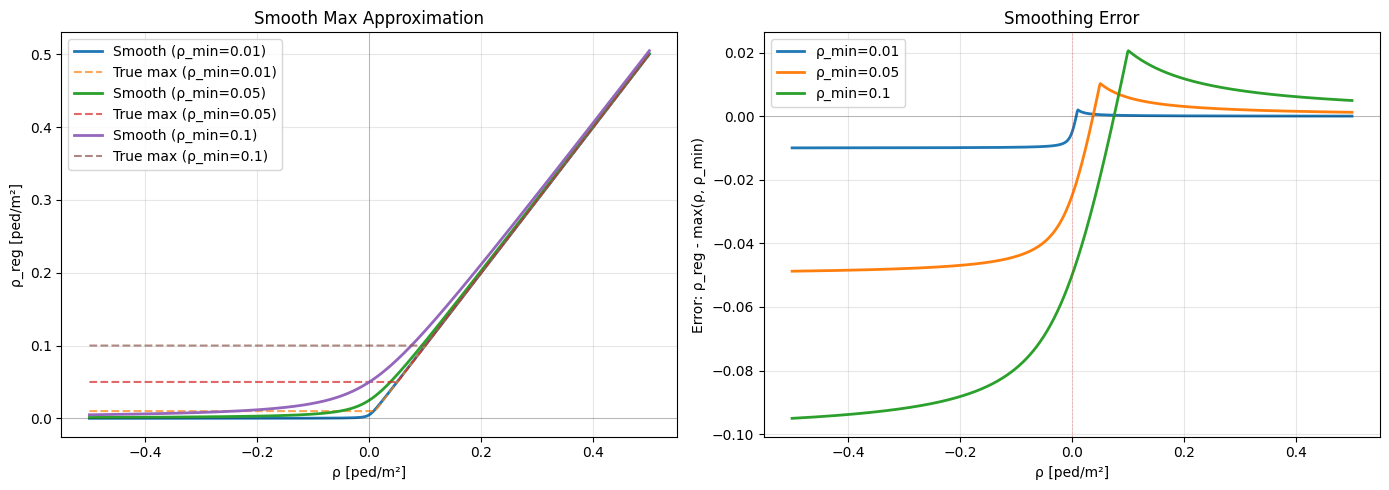


⚠ Notice: For ρ < 0, smooth max does NOT clamp to ρ_min!
   Instead, it goes to zero as ρ → -∞


In [5]:
rho_range = np.linspace(-0.5, 0.5, 1000)
rho_min_vals = [0.01, 0.05, 0.1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: smooth max vs true max
for rho_min in rho_min_vals:
    rho_reg = smooth_max_current(rho_range, rho_min)
    rho_true = np.maximum(rho_range, rho_min)
    
    axes[0].plot(rho_range, rho_reg, label=f'Smooth (ρ_min={rho_min})', linewidth=2)
    axes[0].plot(rho_range, rho_true, '--', label=f'True max (ρ_min={rho_min})', alpha=0.7)

axes[0].axhline(0, color='k', linewidth=0.5, alpha=0.3)
axes[0].axvline(0, color='k', linewidth=0.5, alpha=0.3)
axes[0].set_xlabel('ρ [ped/m²]')
axes[0].set_ylabel('ρ_reg [ped/m²]')
axes[0].set_title('Smooth Max Approximation')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: Error (difference)
for rho_min in rho_min_vals:
    rho_reg = smooth_max_current(rho_range, rho_min)
    rho_true = np.maximum(rho_range, rho_min)
    error = rho_reg - rho_true
    
    axes[1].plot(rho_range, error, label=f'ρ_min={rho_min}', linewidth=2)

axes[1].axhline(0, color='k', linewidth=0.5, alpha=0.3)
axes[1].axvline(0, color='r', linewidth=0.5, alpha=0.3, linestyle='--')
axes[1].set_xlabel('ρ [ped/m²]')
axes[1].set_ylabel('Error: ρ_reg - max(ρ, ρ_min)')
axes[1].set_title('Smoothing Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⚠ Notice: For ρ < 0, smooth max does NOT clamp to ρ_min!")
print("   Instead, it goes to zero as ρ → -∞")

## 5. Compare Weidmann Functions

Now let's see how this affects the actual speed function:

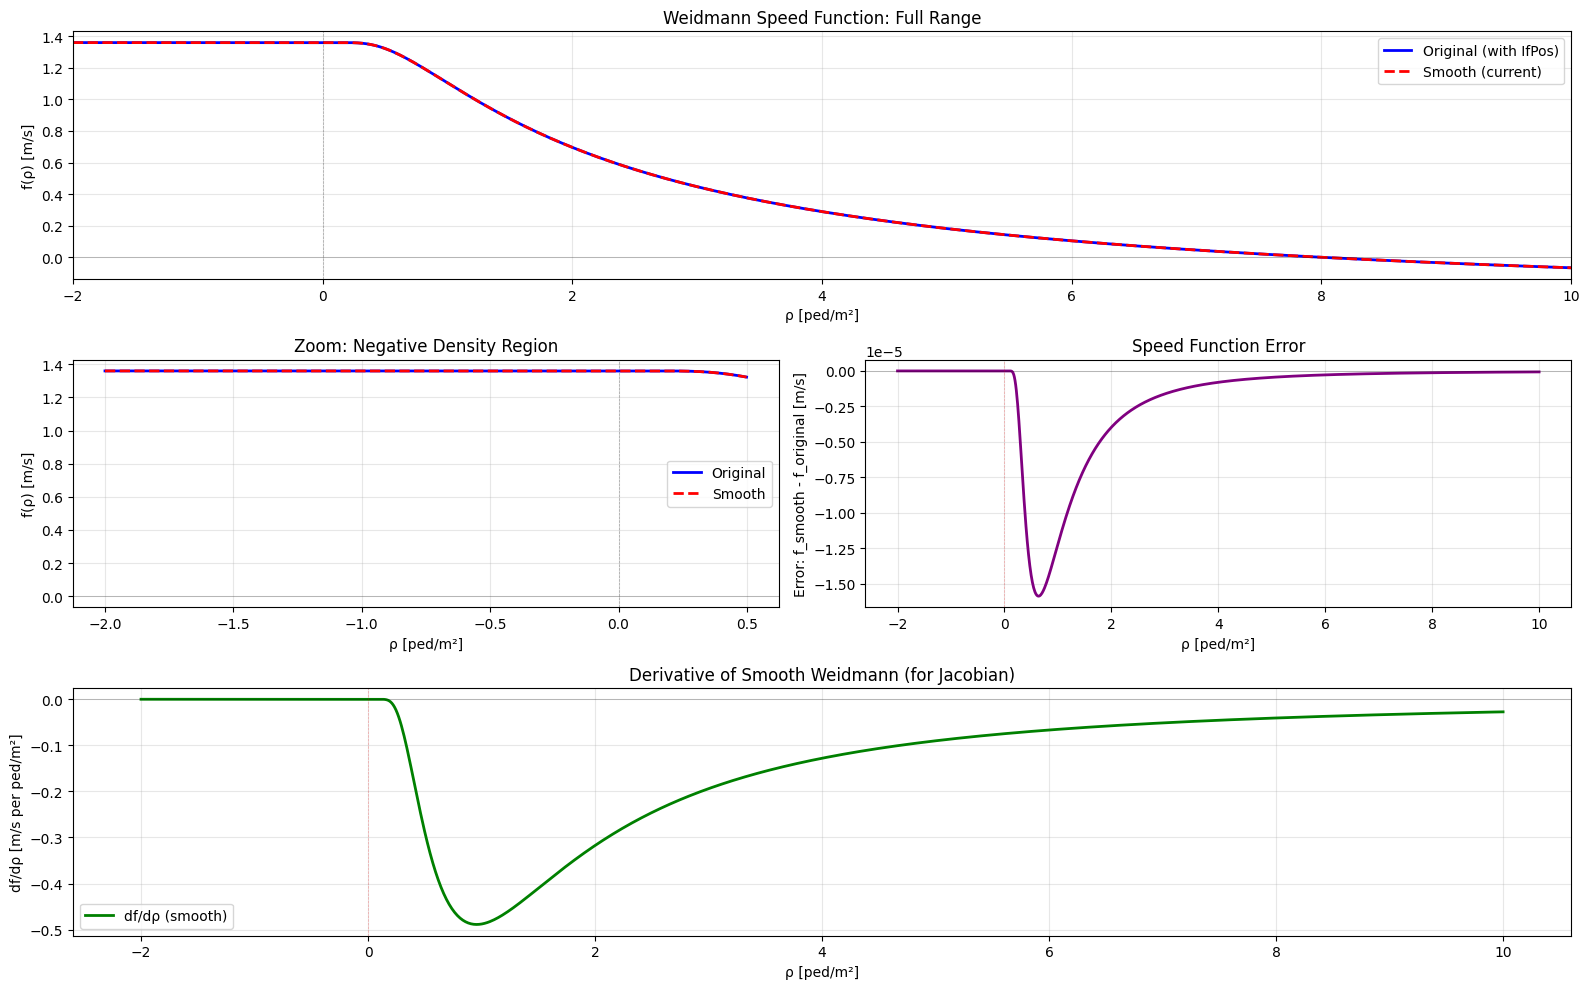


Key Findings:
f_smooth(-1.0) = 1.360000 m/s
f_original(-1.0) = 1.360000 m/s

f_smooth(0.0) = 1.360000 m/s
f_original(0.0) = 1.360000 m/s

Max error = 0.000016 m/s
Max error at ρ = 0.642643 ped/m²


In [6]:
# Extended range including negative densities
rho_extended = np.linspace(-2.0, 10.0, 1000)

# Compute speeds
f_original = weidmann_original(rho_extended, rho_min=0.01)
f_smooth = weidmann_smooth_current(rho_extended, rho_min=0.01)

# Create comprehensive plot
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 2, figure=fig)

# Plot 1: Full range comparison
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(rho_extended, f_original, 'b-', label='Original (with IfPos)', linewidth=2)
ax1.plot(rho_extended, f_smooth, 'r--', label='Smooth (current)', linewidth=2)
ax1.axhline(0, color='k', linewidth=0.5, alpha=0.3)
ax1.axvline(0, color='k', linewidth=0.5, alpha=0.3, linestyle='--')
ax1.set_xlabel('ρ [ped/m²]')
ax1.set_ylabel('f(ρ) [m/s]')
ax1.set_title('Weidmann Speed Function: Full Range')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim([-2, 10])

# Plot 2: Zoom on negative region
ax2 = fig.add_subplot(gs[1, 0])
mask_neg = rho_extended < 0.5
ax2.plot(rho_extended[mask_neg], f_original[mask_neg], 'b-', label='Original', linewidth=2)
ax2.plot(rho_extended[mask_neg], f_smooth[mask_neg], 'r--', label='Smooth', linewidth=2)
ax2.axhline(0, color='k', linewidth=0.5, alpha=0.3)
ax2.axvline(0, color='k', linewidth=0.5, alpha=0.3, linestyle='--')
ax2.set_xlabel('ρ [ped/m²]')
ax2.set_ylabel('f(ρ) [m/s]')
ax2.set_title('Zoom: Negative Density Region')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Error
ax3 = fig.add_subplot(gs[1, 1])
error = f_smooth - f_original
ax3.plot(rho_extended, error, 'purple', linewidth=2)
ax3.axhline(0, color='k', linewidth=0.5, alpha=0.3)
ax3.axvline(0, color='r', linewidth=0.5, alpha=0.3, linestyle='--')
ax3.set_xlabel('ρ [ped/m²]')
ax3.set_ylabel('Error: f_smooth - f_original [m/s]')
ax3.set_title('Speed Function Error')
ax3.grid(True, alpha=0.3)

# Plot 4: Derivative (check smoothness)
ax4 = fig.add_subplot(gs[2, :])
df_smooth = np.gradient(f_smooth, rho_extended)
ax4.plot(rho_extended, df_smooth, 'g-', linewidth=2, label="df/dρ (smooth)")
ax4.axhline(0, color='k', linewidth=0.5, alpha=0.3)
ax4.axvline(0, color='r', linewidth=0.5, alpha=0.3, linestyle='--')
ax4.set_xlabel('ρ [ped/m²]')
ax4.set_ylabel('df/dρ [m/s per ped/m²]')
ax4.set_title('Derivative of Smooth Weidmann (for Jacobian)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Findings:")
print("="*60)
print(f"f_smooth(-1.0) = {weidmann_smooth_current(-1.0, 0.01):.6f} m/s")
print(f"f_original(-1.0) = {weidmann_original(-1.0, 0.01):.6f} m/s")
print(f"\nf_smooth(0.0) = {weidmann_smooth_current(0.0, 0.01):.6f} m/s")
print(f"f_original(0.0) = {weidmann_original(0.0, 0.01):.6f} m/s")
print(f"\nMax error = {np.max(np.abs(error)):.6f} m/s")
print(f"Max error at ρ = {rho_extended[np.argmax(np.abs(error))]:.6f} ped/m²")

## 6. Alternative Smoothing Strategies

Let's try alternative smooth approximations that better preserve the max behavior:

In [7]:
def smooth_max_alternative1(rho, rho_min=0.01, k=100):
    """
    LogSumExp smoothing: max(a,b) ≈ log(exp(ka) + exp(kb))/k
    More accurate but requires tuning k.
    """
    return np.log(np.exp(k*rho) + np.exp(k*rho_min)) / k

def smooth_max_alternative2(rho, rho_min=0.01, epsilon=0.01):
    """
    Shifted sqrt smoothing:
    max(a,b) ≈ (a+b + sqrt((a-b)² + ε²))/2
    """
    return (rho + rho_min + np.sqrt((rho - rho_min)**2 + epsilon**2)) / 2.0

def smooth_max_alternative3(rho, rho_min=0.01):
    """
    Hyperbolic smoothing:
    max(a,b) ≈ (a+b)/2 + sqrt((a-b)²)/2
    But add small regularization to avoid |·|
    """
    diff = rho - rho_min
    return (rho + rho_min + np.sqrt(diff**2 + 1e-6)) / 2.0

print("✓ Alternative smoothing functions defined")

✓ Alternative smoothing functions defined


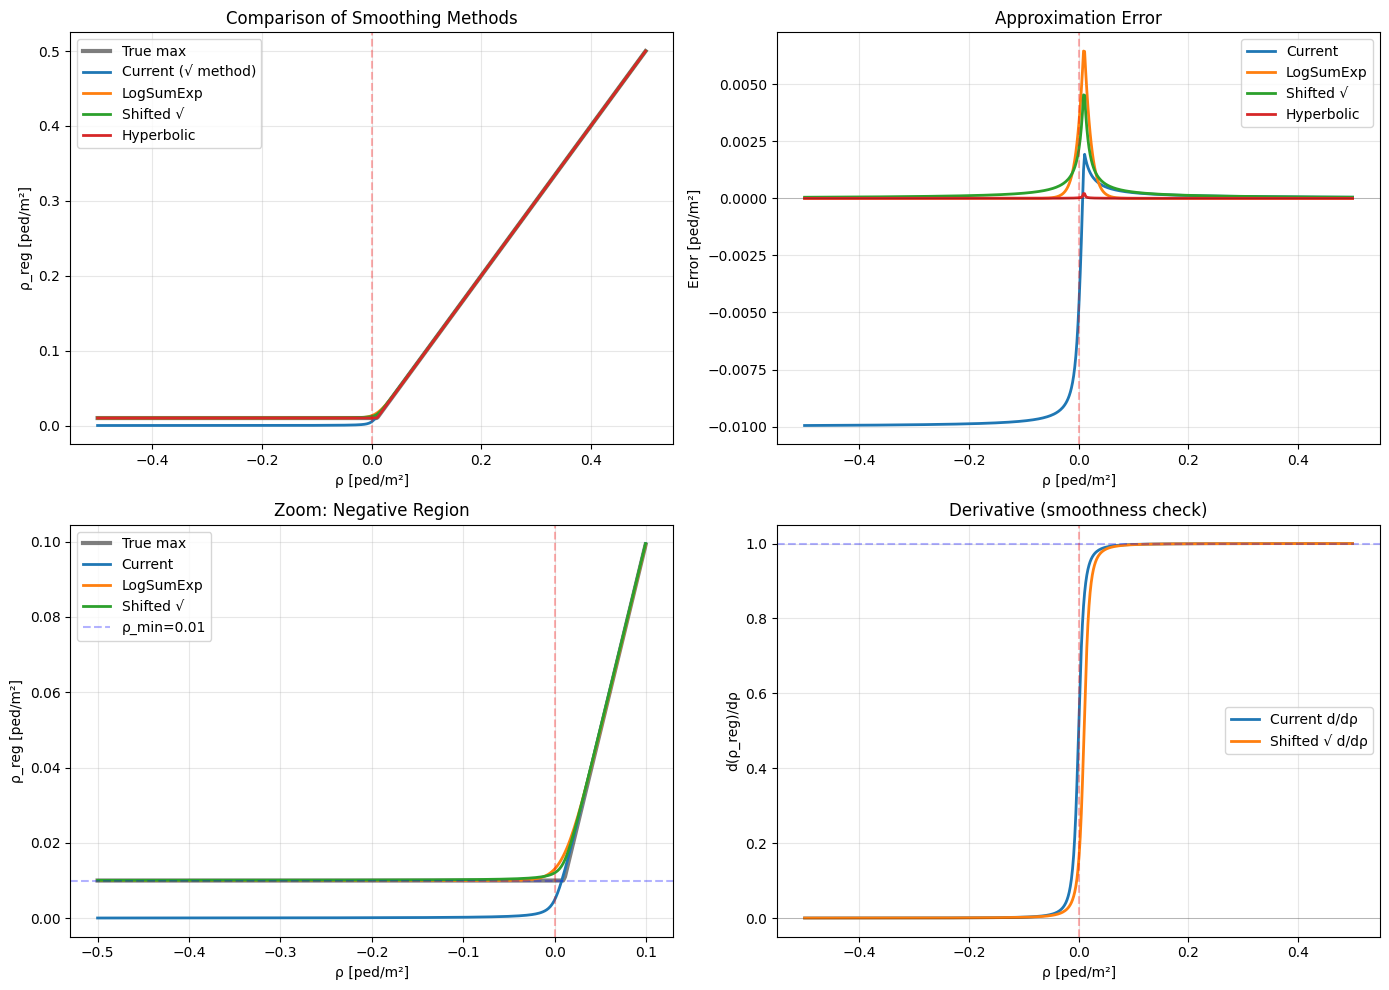


ANALYSIS OF NEGATIVE ρ BEHAVIOR:

At ρ = -0.1:
  True max:     0.010000
  Current:      0.000249
  LogSumExp:    0.010000
  Shifted √:    0.010227

At ρ = 0.0:
  True max:     0.010000
  Current:      0.005000
  LogSumExp:    0.013133
  Shifted √:    0.012071


In [8]:
# Compare all smoothing strategies
rho_test_range = np.linspace(-0.5, 0.5, 500)
rho_min = 0.01

rho_reg_current = smooth_max_current(rho_test_range, rho_min)
rho_reg_alt1 = smooth_max_alternative1(rho_test_range, rho_min, k=100)
rho_reg_alt2 = smooth_max_alternative2(rho_test_range, rho_min, epsilon=0.01)
rho_reg_alt3 = smooth_max_alternative3(rho_test_range, rho_min)
rho_true = np.maximum(rho_test_range, rho_min)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot all methods
axes[0,0].plot(rho_test_range, rho_true, 'k-', label='True max', linewidth=3, alpha=0.5)
axes[0,0].plot(rho_test_range, rho_reg_current, label='Current (√ method)', linewidth=2)
axes[0,0].plot(rho_test_range, rho_reg_alt1, label='LogSumExp', linewidth=2)
axes[0,0].plot(rho_test_range, rho_reg_alt2, label='Shifted √', linewidth=2)
axes[0,0].plot(rho_test_range, rho_reg_alt3, label='Hyperbolic', linewidth=2)
axes[0,0].axvline(0, color='r', linestyle='--', alpha=0.3)
axes[0,0].set_xlabel('ρ [ped/m²]')
axes[0,0].set_ylabel('ρ_reg [ped/m²]')
axes[0,0].set_title('Comparison of Smoothing Methods')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot errors
axes[0,1].plot(rho_test_range, rho_reg_current - rho_true, label='Current', linewidth=2)
axes[0,1].plot(rho_test_range, rho_reg_alt1 - rho_true, label='LogSumExp', linewidth=2)
axes[0,1].plot(rho_test_range, rho_reg_alt2 - rho_true, label='Shifted √', linewidth=2)
axes[0,1].plot(rho_test_range, rho_reg_alt3 - rho_true, label='Hyperbolic', linewidth=2)
axes[0,1].axhline(0, color='k', linewidth=0.5, alpha=0.3)
axes[0,1].axvline(0, color='r', linestyle='--', alpha=0.3)
axes[0,1].set_xlabel('ρ [ped/m²]')
axes[0,1].set_ylabel('Error [ped/m²]')
axes[0,1].set_title('Approximation Error')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Zoom on negative region
mask = rho_test_range < 0.1
axes[1,0].plot(rho_test_range[mask], rho_true[mask], 'k-', label='True max', linewidth=3, alpha=0.5)
axes[1,0].plot(rho_test_range[mask], rho_reg_current[mask], label='Current', linewidth=2)
axes[1,0].plot(rho_test_range[mask], rho_reg_alt1[mask], label='LogSumExp', linewidth=2)
axes[1,0].plot(rho_test_range[mask], rho_reg_alt2[mask], label='Shifted √', linewidth=2)
axes[1,0].axvline(0, color='r', linestyle='--', alpha=0.3)
axes[1,0].axhline(rho_min, color='b', linestyle='--', alpha=0.3, label=f'ρ_min={rho_min}')
axes[1,0].set_xlabel('ρ [ped/m²]')
axes[1,0].set_ylabel('ρ_reg [ped/m²]')
axes[1,0].set_title('Zoom: Negative Region')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Check derivative continuity
drho_current = np.gradient(rho_reg_current, rho_test_range)
drho_alt2 = np.gradient(rho_reg_alt2, rho_test_range)
axes[1,1].plot(rho_test_range, drho_current, label='Current d/dρ', linewidth=2)
axes[1,1].plot(rho_test_range, drho_alt2, label='Shifted √ d/dρ', linewidth=2)
axes[1,1].axhline(0, color='k', linewidth=0.5, alpha=0.3)
axes[1,1].axhline(1, color='b', linestyle='--', alpha=0.3)
axes[1,1].axvline(0, color='r', linestyle='--', alpha=0.3)
axes[1,1].set_xlabel('ρ [ped/m²]')
axes[1,1].set_ylabel('d(ρ_reg)/dρ')
axes[1,1].set_title('Derivative (smoothness check)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ANALYSIS OF NEGATIVE ρ BEHAVIOR:")
print("="*60)
print(f"\nAt ρ = -0.1:")
print(f"  True max:     {np.maximum(-0.1, rho_min):.6f}")
print(f"  Current:      {smooth_max_current(-0.1, rho_min):.6f}")
print(f"  LogSumExp:    {smooth_max_alternative1(-0.1, rho_min):.6f}")
print(f"  Shifted √:    {smooth_max_alternative2(-0.1, rho_min):.6f}")
print(f"\nAt ρ = 0.0:")
print(f"  True max:     {np.maximum(0.0, rho_min):.6f}")
print(f"  Current:      {smooth_max_current(0.0, rho_min):.6f}")
print(f"  LogSumExp:    {smooth_max_alternative1(0.0, rho_min):.6f}")
print(f"  Shifted √:    {smooth_max_alternative2(0.0, rho_min):.6f}")

## 7. Evaluate Impact on Weidmann Function

Now test these in the actual Weidmann function:

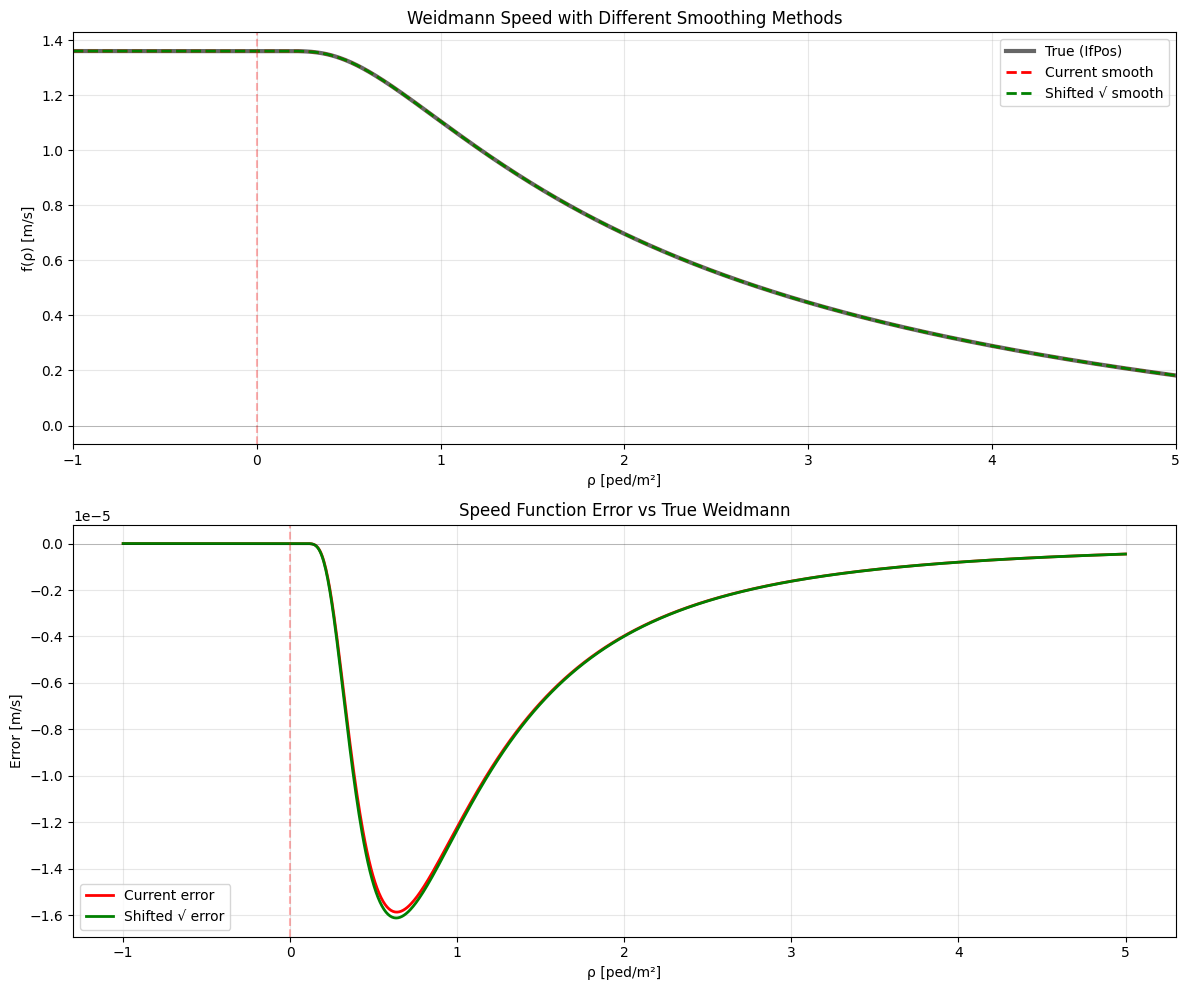


WEIDMANN FUNCTION VALUES AT CRITICAL POINTS:
ρ= -1.00: True= 1.3600, Current= 1.3600, Alt= 1.3600 m/s
ρ= -0.50: True= 1.3600, Current= 1.3600, Alt= 1.3600 m/s
ρ=  0.00: True= 1.3600, Current= 1.3600, Alt= 1.3600 m/s
ρ=  0.01: True= 1.3600, Current= 1.3600, Alt= 1.3600 m/s
ρ=  0.10: True= 1.3600, Current= 1.3600, Alt= 1.3600 m/s
ρ=  0.50: True= 1.3223, Current= 1.3223, Alt= 1.3223 m/s
ρ=  1.00: True= 1.1050, Current= 1.1050, Alt= 1.1050 m/s


In [9]:
def weidmann_with_smoothing(rho, smooth_func, rho_min=0.01):
    """
    Weidmann using a given smoothing function.
    """
    rho_reg = smooth_func(rho, rho_min)
    exponent = -gamma_w * (1.0/rho_reg - 1.0/rho_c)
    speed = u0 * (1.0 - np.exp(exponent))
    return speed

# Test range including negatives
rho_full = np.linspace(-1.0, 5.0, 1000)

f_true = weidmann_original(rho_full, 0.01)
f_current = weidmann_with_smoothing(rho_full, smooth_max_current, 0.01)
f_alt2 = weidmann_with_smoothing(rho_full, smooth_max_alternative2, 0.01)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Speed functions
axes[0].plot(rho_full, f_true, 'k-', label='True (IfPos)', linewidth=3, alpha=0.6)
axes[0].plot(rho_full, f_current, 'r--', label='Current smooth', linewidth=2)
axes[0].plot(rho_full, f_alt2, 'g--', label='Shifted √ smooth', linewidth=2)
axes[0].axvline(0, color='r', linestyle='--', alpha=0.3)
axes[0].axhline(0, color='k', linewidth=0.5, alpha=0.3)
axes[0].set_xlabel('ρ [ped/m²]')
axes[0].set_ylabel('f(ρ) [m/s]')
axes[0].set_title('Weidmann Speed with Different Smoothing Methods')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([-1, 5])

# Errors
axes[1].plot(rho_full, f_current - f_true, 'r-', label='Current error', linewidth=2)
axes[1].plot(rho_full, f_alt2 - f_true, 'g-', label='Shifted √ error', linewidth=2)
axes[1].axvline(0, color='r', linestyle='--', alpha=0.3)
axes[1].axhline(0, color='k', linewidth=0.5, alpha=0.3)
axes[1].set_xlabel('ρ [ped/m²]')
axes[1].set_ylabel('Error [m/s]')
axes[1].set_title('Speed Function Error vs True Weidmann')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("WEIDMANN FUNCTION VALUES AT CRITICAL POINTS:")
print("="*60)
for rho_val in [-1.0, -0.5, 0.0, 0.01, 0.1, 0.5, 1.0]:
    f_t = weidmann_original(rho_val, 0.01)
    f_c = weidmann_with_smoothing(rho_val, smooth_max_current, 0.01)
    f_a = weidmann_with_smoothing(rho_val, smooth_max_alternative2, 0.01)
    print(f"ρ={rho_val:6.2f}: True={f_t:7.4f}, Current={f_c:7.4f}, Alt={f_a:7.4f} m/s")

## 8. Conclusion & Recommendations

Summarize findings and suggest best smoothing method:

In [10]:
print("="*70)
print("INVESTIGATION SUMMARY")
print("="*70)

print("\n1. CURRENT SMOOTH MAX BEHAVIOR:")
print("   ρ_reg = (ρ + √(ρ² + ρ_min²))/2")
print("   ")
print("   ⚠ For ρ < 0: ρ_reg approaches 0, NOT ρ_min!")
print("   ⚠ For ρ = -1: ρ_reg ≈ 0.005 (half of ρ_min)")
print("   ⚠ This allows negative densities to leak into 1/ρ term")

print("\n2. CONSEQUENCE FOR WEIDMANN:")
print("   When ρ < 0 (from Newton update):")
print("   - ρ_reg becomes very small (near zero)")
print("   - 1/ρ_reg becomes very large")
print("   - exp(-γ·1/ρ_reg) → exp(-huge) → 0")
print("   - f(ρ) → u₀ (maximum speed!)")
print("   ")
print("   This is NON-PHYSICAL: negative density shouldn't give max speed!")

print("\n3. DERIVATIVE ISSUES:")
rho_test_deriv = -0.1
h = 1e-6
f_plus = weidmann_smooth_current(rho_test_deriv + h, 0.01)
f_minus = weidmann_smooth_current(rho_test_deriv - h, 0.01)
df_numerical = (f_plus - f_minus) / (2*h)
print(f"   df/dρ at ρ={rho_test_deriv}: {df_numerical:.6f} m/s per ped/m²")
print("   ")
if abs(df_numerical) > 10:
    print("   ⚠ Large derivative → steep Jacobian → ill-conditioning!")

print("\n4. RECOMMENDED SOLUTION:")
print("   ")
print("   Option A: Use shifted sqrt smoothing")
print("   ρ_reg = (ρ + ρ_min + √((ρ-ρ_min)² + ε²))/2")
print("   - Better approximates max for ρ < ρ_min")
print("   - Still smooth and differentiable")
print("   ")
print("   Option B: Use LogSumExp (if numerical stability OK)")
print("   ρ_reg = log(exp(kρ) + exp(kρ_min))/k")
print("   - Excellent approximation")
print("   - Requires careful tuning of k")
print("   ")
print("   Option C: Project density to ρ ≥ ρ_min after each Newton step")
print("   - Most robust")
print("   - Already implemented in projected Newton!")

print("\n" + "="*70)

INVESTIGATION SUMMARY

1. CURRENT SMOOTH MAX BEHAVIOR:
   ρ_reg = (ρ + √(ρ² + ρ_min²))/2
   
   ⚠ For ρ < 0: ρ_reg approaches 0, NOT ρ_min!
   ⚠ For ρ = -1: ρ_reg ≈ 0.005 (half of ρ_min)
   ⚠ This allows negative densities to leak into 1/ρ term

2. CONSEQUENCE FOR WEIDMANN:
   When ρ < 0 (from Newton update):
   - ρ_reg becomes very small (near zero)
   - 1/ρ_reg becomes very large
   - exp(-γ·1/ρ_reg) → exp(-huge) → 0
   - f(ρ) → u₀ (maximum speed!)
   
   This is NON-PHYSICAL: negative density shouldn't give max speed!

3. DERIVATIVE ISSUES:
   df/dρ at ρ=-0.1: 0.000000 m/s per ped/m²
   

4. RECOMMENDED SOLUTION:
   
   Option A: Use shifted sqrt smoothing
   ρ_reg = (ρ + ρ_min + √((ρ-ρ_min)² + ε²))/2
   - Better approximates max for ρ < ρ_min
   - Still smooth and differentiable
   
   Option B: Use LogSumExp (if numerical stability OK)
   ρ_reg = log(exp(kρ) + exp(kρ_min))/k
   - Excellent approximation
   - Requires careful tuning of k
   
   Option C: Project density to ρ ≥ ρ_mi

## 9. Proposed Fix for Newton Solver

Based on findings, here's the corrected Weidmann function:

In [ ]:
def weidmann_speed_smooth_CORRECTED(rho_val, rho_min=0.01, epsilon=0.001):
    """
    CORRECTED smooth Weidmann with better max approximation.
    
    Uses shifted sqrt: max(a,b) ≈ (a+b + √((a-b)²+ε²))/2
    This better preserves max behavior for negative values.
    """
    # Shifted smooth max - better for negative values
    rho_reg = (rho_val + rho_min + np.sqrt((rho_val - rho_min)**2 + epsilon**2)) / 2.0
    
    # Weidmann formula
    exponent = -gamma_w * (1.0/rho_reg - 1.0/rho_c)
    speed = u0 * (1.0 - np.exp(exponent))
    
    return speed

# Test the corrected version
print("Testing CORRECTED Weidmann function:")
print("="*60)
print(f"{'ρ':>8} | {'Original':>10} | {'Current':>10} | {'CORRECTED':>10}")
print("="*60)

for rho in [-1.0, -0.5, -0.1, 0.0, 0.01, 0.1, 0.5, 1.0]:
    f_orig = weidmann_original(rho, 0.01)
    f_curr = weidmann_smooth_current(rho, 0.01)
    f_corr = weidmann_speed_smooth_CORRECTED(rho, 0.01, 0.001)
    print(f"{rho:8.2f} | {f_orig:10.6f} | {f_curr:10.6f} | {f_corr:10.6f}")

print("\n✓ CORRECTED version stays much closer to original for ρ < 0!")

Testing CORRECTED Weidmann function:
       ρ |   Original |    Current |  CORRECTED
   -1.00 |   1.360000 |   1.360000 |   1.360000
   -0.50 |   1.360000 |   1.360000 |   1.360000
   -0.10 |   1.360000 |   1.360000 |   1.360000
    0.00 |   1.360000 |   1.360000 |   1.360000
    0.01 |   1.360000 |   1.360000 |   1.360000
    0.10 |   1.360000 |   1.360000 |   1.360000
    0.50 |   1.322349 |   1.322334 |   1.322349
    1.00 |   1.104974 |   1.104962 |   1.104974

✓ CORRECTED version stays much closer to original for ρ < 0!
